In [13]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [14]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb40_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/Sex_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 3

In [15]:
participants = pd.read_csv(participants_file, index_col=0)


In [16]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [17]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [18]:
participants = participants[[label]].dropna()

array([[<AxesSubplot:title={'center':'Sex'}>]], dtype=object)

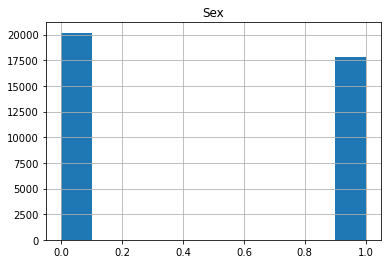

In [19]:
participants.hist()

In [20]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [21]:
model_paths = get_model_paths(path_champollion)

In [22]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-37-43_111',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-40-14_1',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-40-08_233',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-39-35_196']

In [23]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [24]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-37-43_111 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-37-43_111
31.32515110835602
Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
30.694222252559232
Treating S.C.-sylv._left: SC-sylv_left/11-40-14_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-40-14_1
32.61365669822023
Treating S.C.-sylv._left: SC-sylv_left/11-40-08_233 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-40-08_233
31.360940840804133
Treating S.C.-sylv._left: SC-sylv_left/11-39-35_196 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-39-35_196
30.687114779564773
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
30.481603464356088
Treating S.F.inter.-S.F.sup._lef

In [25]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [26]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,31.325151,0.0,11-37-43_111,SC-sylv_left/11-37-43_111,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,30.694222,0.0,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
2,S.C.-sylv._left,32.613657,0.0,11-40-14_1,SC-sylv_left/11-40-14_1,/neurospin/dico/data/deep_folding/current/mode...
3,S.C.-sylv._left,31.360941,0.0,11-40-08_233,SC-sylv_left/11-40-08_233,/neurospin/dico/data/deep_folding/current/mode...
4,S.C.-sylv._left,30.687115,0.0,11-39-35_196,SC-sylv_left/11-39-35_196,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
291,S.C.-S.Po.C._left,36.000756,0.0,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...
292,S.C.-S.Po.C._left,35.520488,0.0,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...
293,S.C.-S.Po.C._left,33.131815,0.0,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...
294,S.C.-S.Po.C._left,32.891860,0.0,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...


In [27]:
df['side'] = df['region'].str.split('_').str[-1]

In [28]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05), color='black', linestyle='-')
    ax.axvline(x=-np.log10(0.05/56), color='red', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [29]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
17,F.Coll.-S.Rh._right,74.614116,0.0,12-20-19_187,FColl-SRh_right/12-20-19_187,/neurospin/dico/data/deep_folding/current/mode...,right
19,F.Coll.-S.Rh._right,74.151751,0.0,12-20-18_252,FColl-SRh_right/12-20-18_252,/neurospin/dico/data/deep_folding/current/mode...,right
20,F.Coll.-S.Rh._right,71.978196,0.0,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
16,F.Coll.-S.Rh._right,71.272370,0.0,12-20-16_75,FColl-SRh_right/12-20-16_75,/neurospin/dico/data/deep_folding/current/mode...,right
18,F.Coll.-S.Rh._right,71.146236,0.0,12-17-52_12,FColl-SRh_right/12-17-52_12,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
264,S.F.marginal-S.F.inf.ant._right,11.403937,0.0,18-21-09_28_0,SFmarginal-SFinfant_right/18-21-09_28_0,/neurospin/dico/data/deep_folding/current/mode...,right
262,S.F.marginal-S.F.inf.ant._right,10.611715,0.0,18-20-10_74_0,SFmarginal-SFinfant_right/18-20-10_74_0,/neurospin/dico/data/deep_folding/current/mode...,right
261,S.F.marginal-S.F.inf.ant._right,10.161995,0.0,18-20-22_204_0,SFmarginal-SFinfant_right/18-20-22_204_0,/neurospin/dico/data/deep_folding/current/mode...,right
265,S.F.marginal-S.F.inf.ant._right,9.971018,0.0,18-18-22_38_0,SFmarginal-SFinfant_right/18-18-22_38_0,/neurospin/dico/data/deep_folding/current/mode...,right


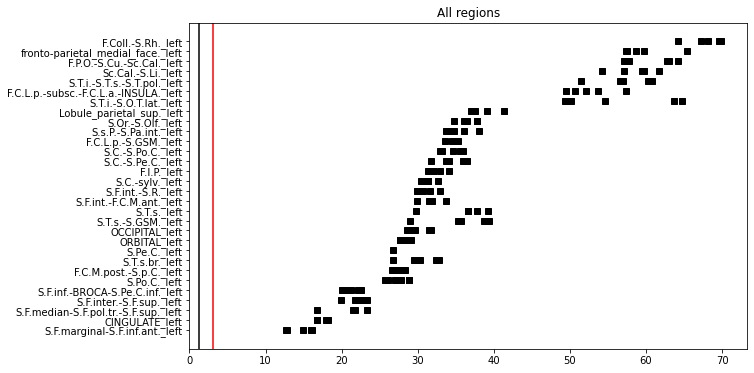

In [30]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

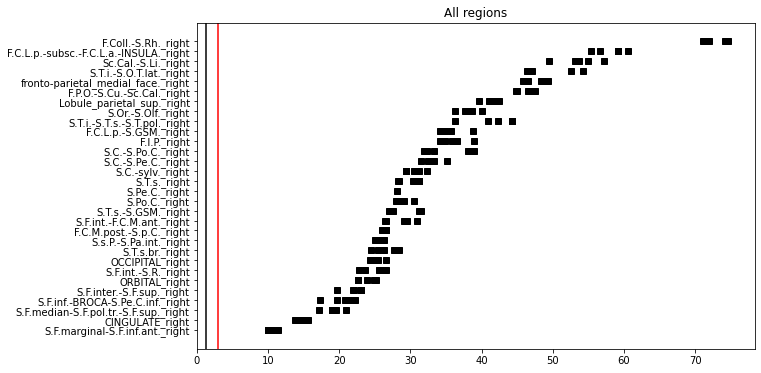

In [31]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [32]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,31.325151,0.0,11-37-43_111,SC-sylv_left/11-37-43_111,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,30.694222,0.0,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.C.-sylv._left,32.613657,0.0,11-40-14_1,SC-sylv_left/11-40-14_1,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.C.-sylv._left,31.360941,0.0,11-40-08_233,SC-sylv_left/11-40-08_233,/neurospin/dico/data/deep_folding/current/mode...,left
4,S.C.-sylv._left,30.687115,0.0,11-39-35_196,SC-sylv_left/11-39-35_196,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
291,S.C.-S.Po.C._left,36.000756,0.0,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...,left
292,S.C.-S.Po.C._left,35.520488,0.0,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...,left
293,S.C.-S.Po.C._left,33.131815,0.0,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...,left
294,S.C.-S.Po.C._left,32.891860,0.0,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...,left


In [33]:
# df.to_csv(output_filename)